In [1]:
import sys

In [2]:
sys.path.append('../code/')

In [3]:
from training_data_handler import TrainingDataHandler

/home/veton/anaconda3/envs/bfh/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
tdh = TrainingDataHandler()

In [25]:
tdh.get_training_data(languages=['de'], affair_text_scope=['zh','ch'], inputs=['text'])


In [26]:
tdh.training_data_df[['title','language','split']].groupby(['language','split']).count()

title
language split            
de       test        18911
         train       56731
         validation  18910

In [21]:
tdh.training_data_df[['title','language','split']].groupby(['language','split']).count()

title
language split            
de       test        18796
         train       56828
         validation  18928
fr       test        17994
         train       53531
         validation  17896
it       test        13668
         train       41015
         validation  13634

,affair_text_scope,affair_text_srcid,affair_text_date_staged,text_name_de,text_name_fr,text_name_it,text_fr,text_it,source,affair_attachment_title,...,Sicherheit,Soziale Frage,Sozialer Schutz,Strategien im Gesundheitssystem,Sucht-Substanzen,Umwelt,Verkehr,Wirtschaft,one_hot_affair_topic_codes,split


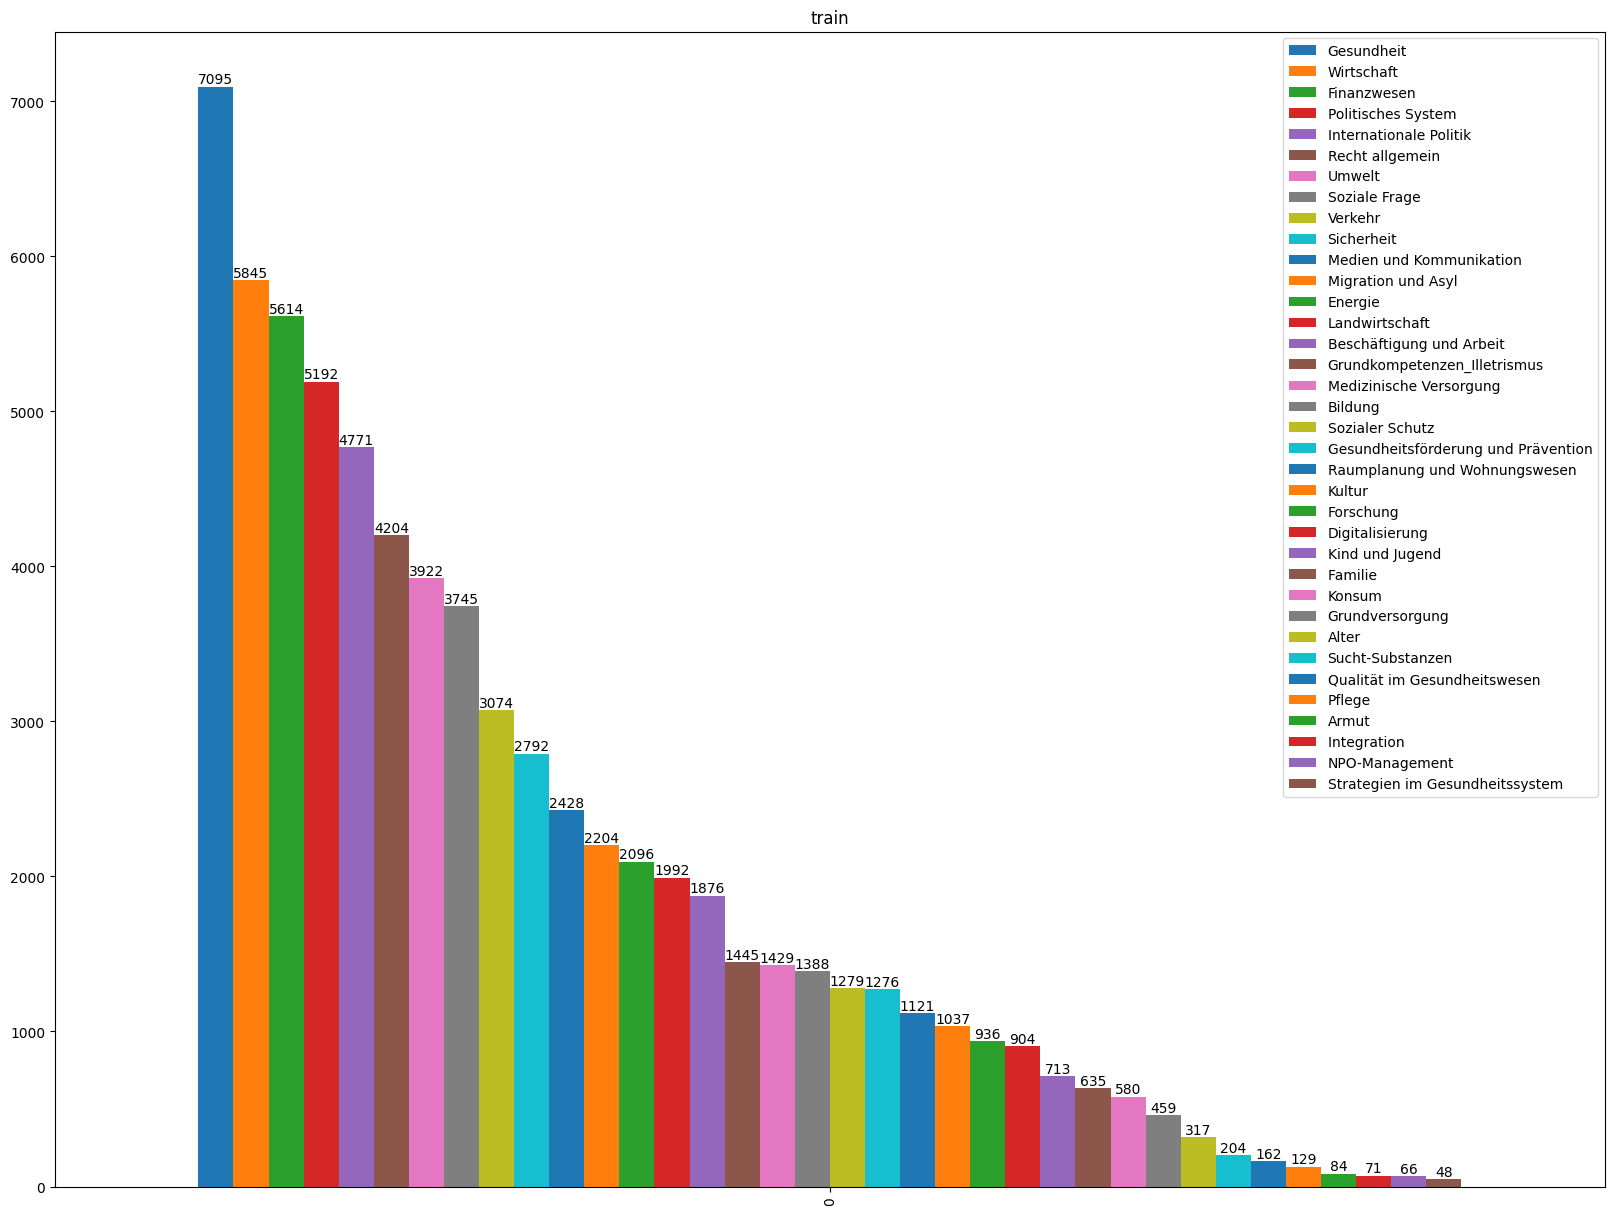

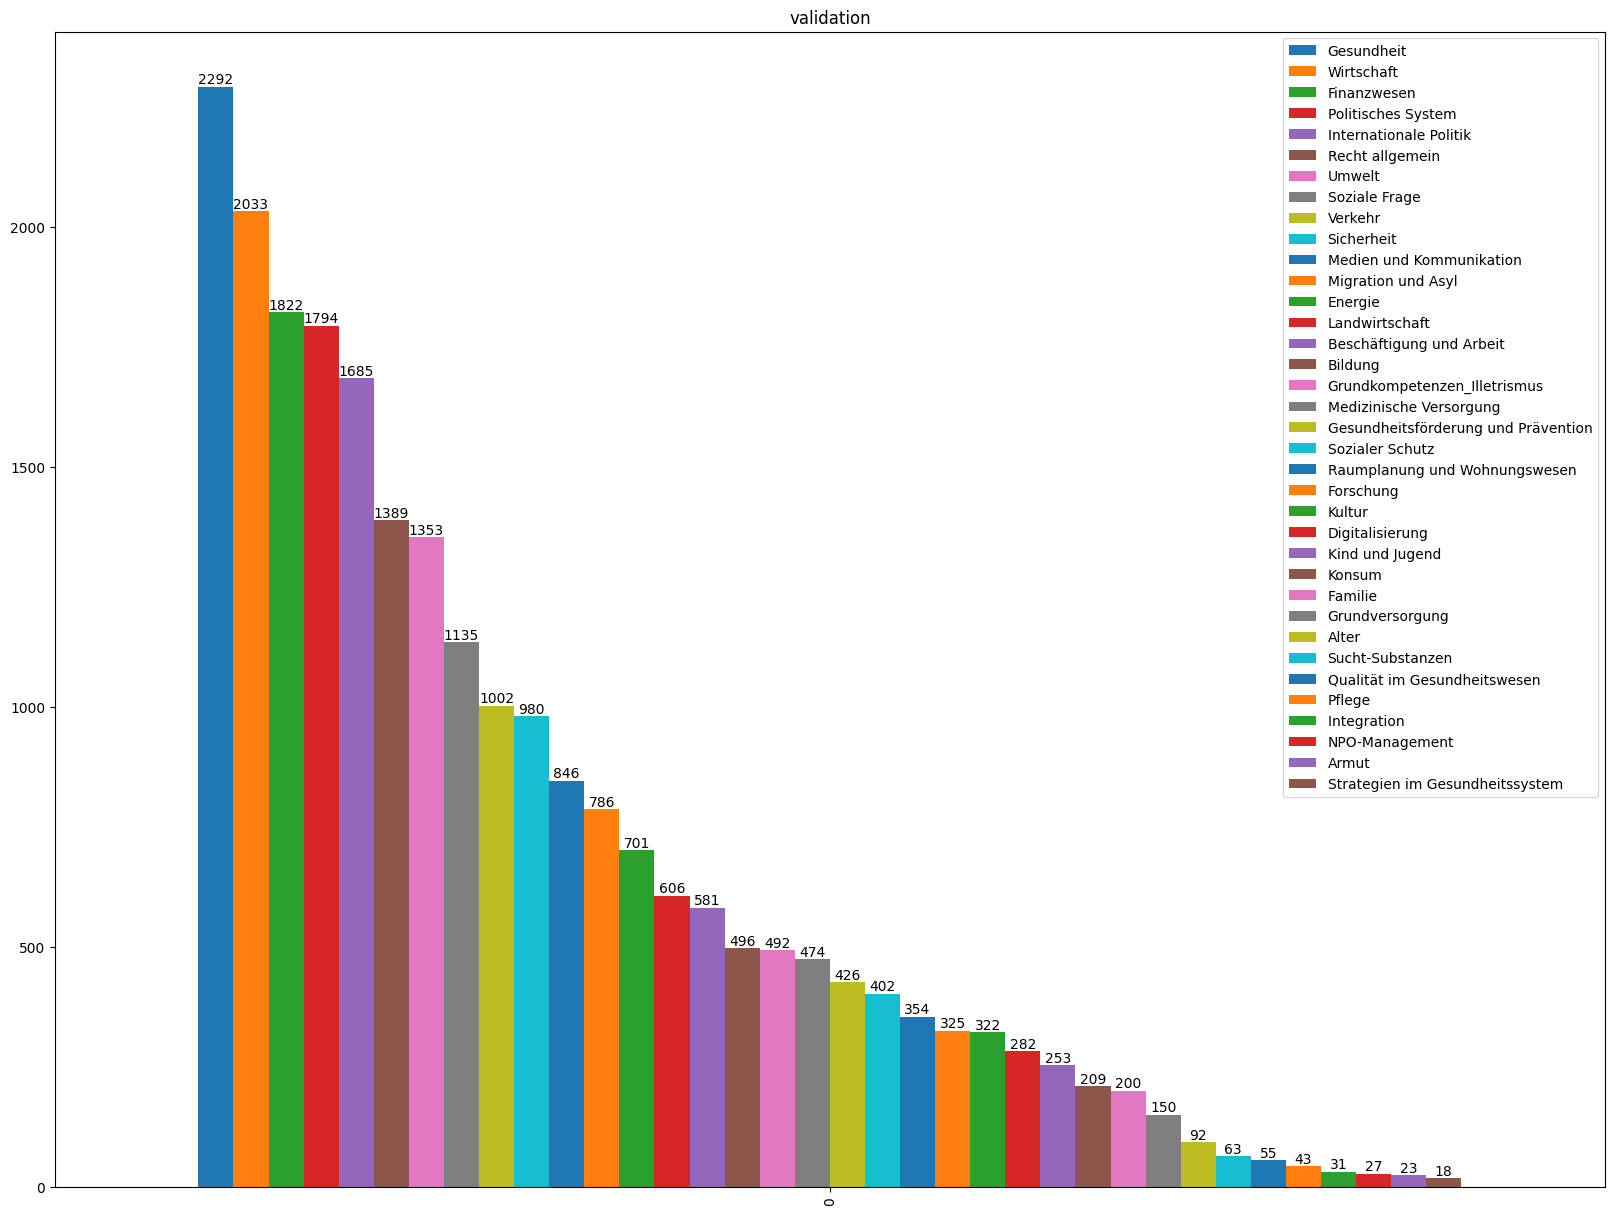

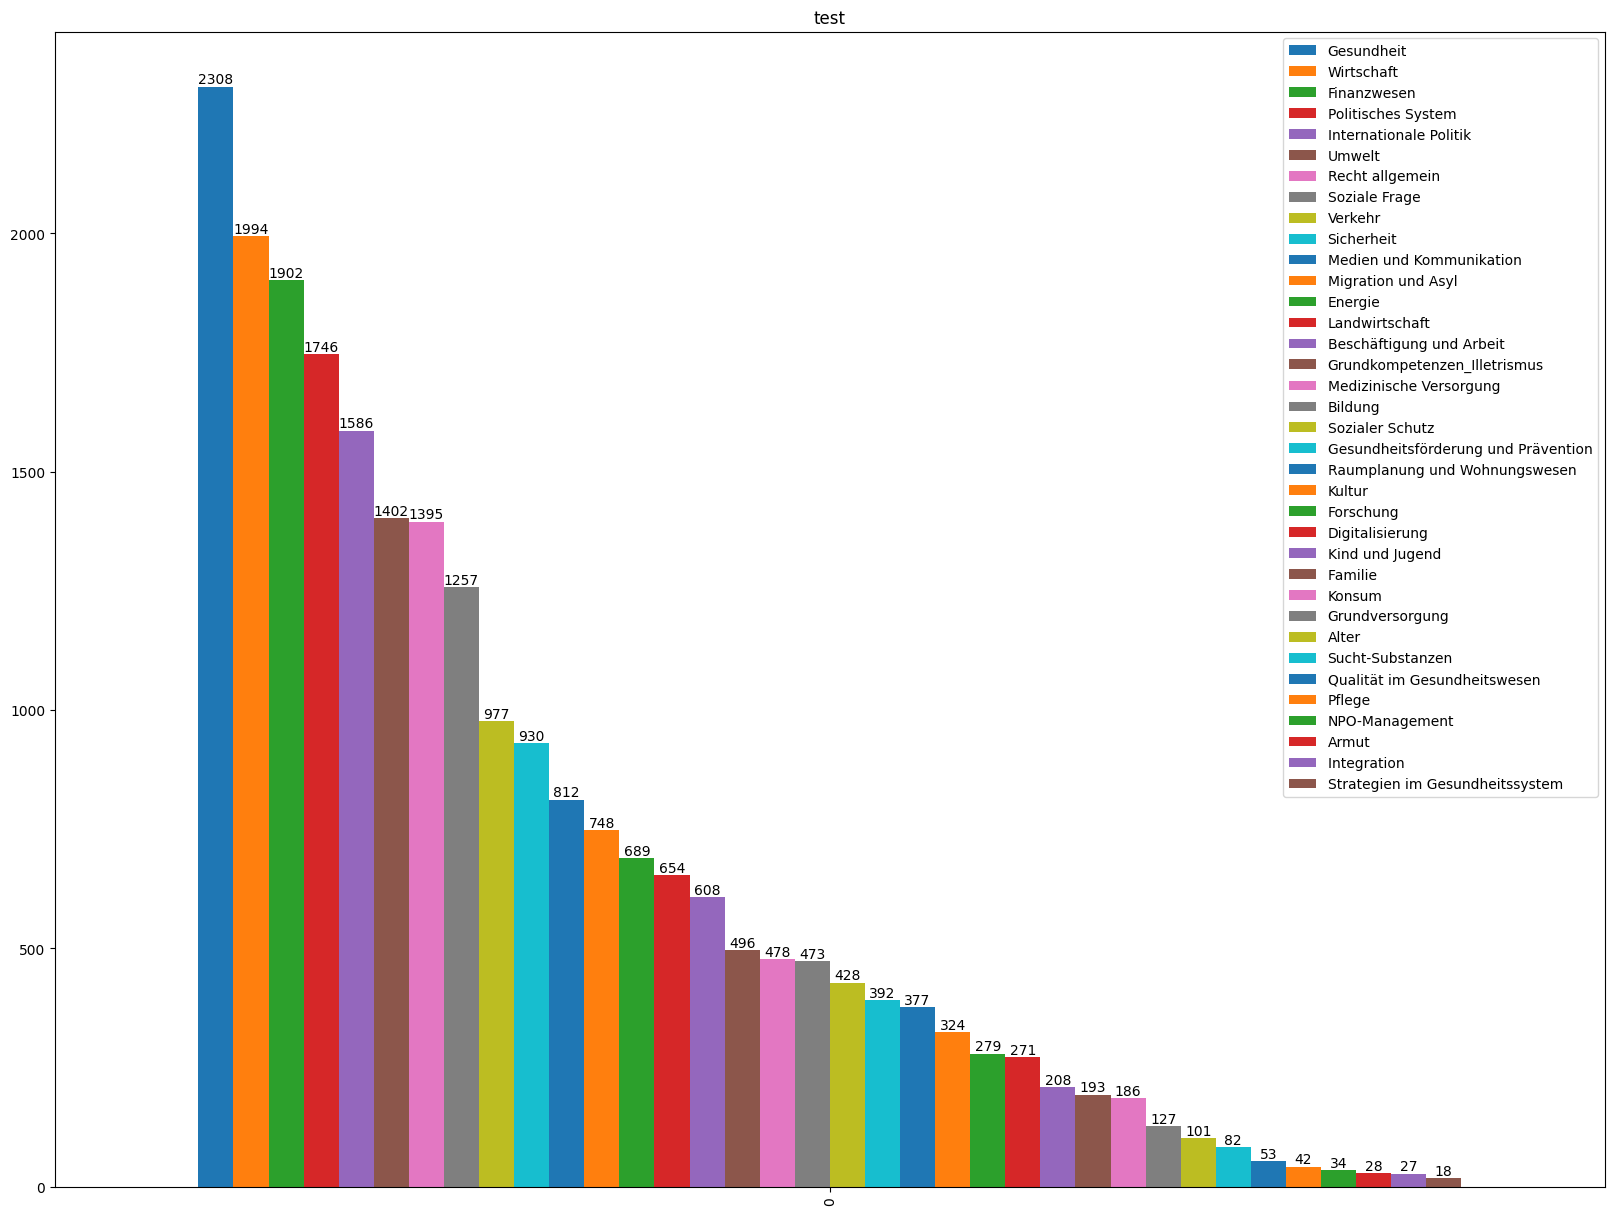

In [16]:
for split in ['train', 'validation', 'test']:
    tdh.create_barplot(tdh.training_data_df[tdh.training_data_df.split==split], split)

In [ ]:
tdh.training_data_df[['text_de','affair_topic_codes_as_labels','split']]

In [ ]:
tdh.filter_training_data(languages='all', affair_text_scope='all', inputs='all')

In [ ]:
tdh.raw_data_for_training.shape


In [ ]:
raw_data_for_training = pd.read_json('../data/raw_data_for_training.jsonl', lines=True)
raw_data_for_training_ch_zh = raw_data_for_training[raw_data_for_training.affair_text_scope.isin(['zh','ch'])]
raw_data_for_training.head()

In [ ]:
raw_data_for_training.columns.tolist()

## 1. Data analysis


In [ ]:
print("The raw training data set has ", raw_data_for_training.shape[0], " examples.")
print("Each affair_text_srcid can have several texts, such as title, Vorstoss etc.")
print("If we count only the unique values of affair_text_srcid we get ", raw_data_for_training.drop_duplicates('affair_text_srcid').shape[0], " examples")
print(raw_data_for_training.drop_duplicates('affair_text_srcid').shape[0], " is the total number of examples we can work with.")
print("If we keep only the data from Zurich and Switzerland (Bund), we have ", raw_data_for_training_ch_zh.drop_duplicates('affair_text_srcid').shape[0], " examples.")


- Counting how often each label occurs
- First we do a simple count: How often does each label occur per text or row

In [ ]:
# Creating overview of the frequency of all labels

def create_barplot(df, title=''):

    all_labels = list()
    for label_list in df.affair_topic_codes_as_labels:
        for label in label_list:
            all_labels.append(label)

    labels_counted = dict(Counter(all_labels))
    labels_counted = dict(sorted([x for x in labels_counted.items()], key=lambda x: x[1], reverse=True))
    #for label, count in labels_counted.items():
        #print(label,': ',count, end=' ; ')
    plot_data = pd.DataFrame([labels_counted]) 
    plot_data = plot_data.sort_values(by=0, ascending=False, axis=1)
    ax = plot_data.plot.bar(figsize = (20,15), width=2.2, title=title)
    for container in ax.containers:
        ax.bar_label(container)
        
create_barplot(raw_data_for_training,'Frequency of each label per text.')

- However, each affair_text_srcid can have several texts, such as title, Vorstoss etc.
- We will keep only uniques rows based on affair_text_srcid and then make a count


In [ ]:
create_barplot(raw_data_for_training.drop_duplicates('affair_text_srcid'),'Frequency of each label per unique affair_text_srcid.')

- In the following alos the same plots for the data filtered by ch and zh


In [ ]:
create_barplot(raw_data_for_training_ch_zh,'Frequency of each label per text only for ch and zh.')
create_barplot(raw_data_for_training_ch_zh.drop_duplicates('affair_text_srcid'),'Frequency of each label per unique affair_text_srcid only for ch and zh.')

- Co-occurence analysis

In [ ]:
corr = data_for_split_df[list(label2id.keys())].corr()
corr.style.background_gradient(cmap='coolwarm')

## 2. Create split


- Next we need to create a train, validation, test split
- According to [this post](https://medium.com/gumgum-tech/creating-balanced-multi-label-datasets-for-model-training-and-evaluation-16b6a3a2d912) this package is good: https://github.com/trent-b/iterative-stratification
- Therefore, I will use this python package: https://github.com/trent-b/iterative-stratification
- The splits will be done only on the unique affair_text_srcid
- We will do the first split only on the basis of the data for *ch* and *zh*


In [ ]:
with open('../utils/label2id.json') as f:
    label2id = js.load(f)


def create_df_for_split(initial_df, colum_for_duplicate_removal='affair_text_srcid'):    
    
    initial_df = initial_df.drop_duplicates(colum_for_duplicate_removal)


    data_for_split = list()

    for r in initial_df.to_dict(orient='records'):
        item = dict()
        affair_text_srcid = r['affair_text_srcid']
        affair_topic_codes_as_labels = r['affair_topic_codes_as_labels']
        affair_topic_codes = r['affair_topic_codes']
        item['affair_text_srcid'] = affair_text_srcid
        item['affair_topic_codes_as_labels'] = affair_topic_codes_as_labels
        item['affair_topic_codes'] = affair_topic_codes

        one_hot_affair_topic_codes = []
        for label in sorted(list(label2id.keys())):
            if label in affair_topic_codes_as_labels:
                item[label]=1
                one_hot_affair_topic_codes.append(1)
            else:
                item[label]=0
                one_hot_affair_topic_codes.append(0)

        item['one_hot_affair_topic_codes'] = one_hot_affair_topic_codes

        data_for_split.append(item)

    data_for_split_df = pd.DataFrame(data_for_split)
    
    data_for_split_df = data_for_split_df.reset_index(drop=True)
    
    return data_for_split_df
    


In [ ]:
create_df_for_split(raw_data_for_training_ch_zh)

In [ ]:
# https://github.com/trent-b/iterative-stratification



X = np.array(['Bla', 'bla', 'bla', 'bla', 'bla', 'bla', 'bla', 'bla'])
y = np.array([[0,0,1], [0,0,0], [1,0,1], [1,0,1], [1,1,1], [0,1,1], [1,0,0], [1,0,0]])



def create_split(dataframe, test_size=0.4):
    
    if 'split' not in dataframe.columns:
        dataframe['split']=''
    
    X = dataframe.affair_text_srcid.values
    y = np.array(dataframe.one_hot_affair_topic_codes.tolist())
    
    msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=0)

    for train_index, test_index in msss.split(X, y):
        dataframe.loc[(dataframe.index.isin(train_index)), 'split'] = 'train'
        dataframe.loc[(dataframe.index.isin(test_index)), 'split'] = 'other'
        
        dataframe_filtered = dataframe[dataframe.split=='other'].reset_index(drop=False)
        X = dataframe_filtered.affair_text_srcid.values
        y = np.array(dataframe_filtered.one_hot_affair_topic_codes.tolist())
        
        msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=0)

        for validation_index, test_index in msss.split(X, y):
            for i,_ in dataframe_filtered.iterrows():
                _index = dataframe_filtered.at[i, 'index']
                if i in validation_index:
                    dataframe.at[_index,'split']='validation'
                if i in test_index:
                    dataframe.at[_index,'split']='test'
            
    return dataframe
    


In [ ]:
data_for_split_df = create_df_for_split(raw_data_for_training_ch_zh)

data_for_split_df = create_split(data_for_split_df)
data_for_split_df

In [ ]:
data_for_split_df[['affair_text_srcid', 'split']].groupby('split').count().plot.bar()

- Checking if the labels have an equal distribution over all splits


In [ ]:
for split in ['train', 'validation', 'test']:
    train_affair_text_srcid = data_for_split_df[data_for_split_df.split==split].affair_text_srcid.tolist()
    train_affair_text_srcid = [int(x) for x in train_affair_text_srcid]
    create_barplot(raw_data_for_training_ch_zh_unique[(raw_data_for_training_ch_zh_unique.affair_text_srcid.isin(train_affair_text_srcid))], title=split)

## 3. Train model


In [ ]:
from datasets import Dataset


In [ ]:
Dataset.from_list

In [ ]:
from datasets import load_dataset
from sentence_transformers.losses import CosineSimilarityLoss

from setfit import SetFitModel, SetFitTrainer, sample_dataset


# Load a dataset from the Hugging Face Hub
# dataset = load_dataset("sst2")



dataset = load_dataset("joelito/lextreme", "covid19_emergency_event")

# Simulate the few-shot regime by sampling 8 examples per class
train_dataset = dataset["train"] #[:20]
eval_dataset = dataset["validation"]
train_dataset = train_dataset.remove_columns('language')
eval_dataset = eval_dataset.remove_columns('language')

# Load a SetFit model from Hub
model = SetFitModel.from_pretrained(
    "sentence-transformers/paraphrase-mpnet-base-v2",
    multi_target_strategy="one-vs-rest",
)

# Create trainer
trainer = SetFitTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    loss_class=CosineSimilarityLoss,
    metric="accuracy",
    batch_size=16,
    num_iterations=20, # The number of text pairs to generate for contrastive learning
    num_epochs=1, # The number of epochs to use for contrastive learning
    column_mapping={"input": "text", "label": "label"} # Map dataset columns to text/label expected by trainer
)

# Train and evaluate
trainer.train()
metrics = trainer.evaluate()

# Push model to the Hub
trainer.push_to_hub("my-awesome-setfit-model")

# Download from Hub and run inference
model = SetFitModel.from_pretrained("lewtun/my-awesome-setfit-model")
# Run inference
preds = model(["i loved the spiderman movie!", "pineapple on pizza is the worst 🤮"])

In [ ]:
train_dataset

In [ ]:
sample_dataset?

In [ ]:
train_dataset = sample_dataset(dataset["train"], label_column="label", num_samples=8)

In [ ]:
dataset['train'] #.features['label'].feature.names

## Old Code

In [ ]:
df = pd.read_excel('../data/Data/affairs.xlsx')
#df = df[df.affair_scope=="zh"]
df = df[df.affair_topic_codes.isin(['1696','other'])]
df = df[df.affair_topic_codes.isnull()==False]
df.shape

In [ ]:
label2id = dict()

topic_labels = pd.read_excel('../data/topics_politmonitor.xlsx')

for r in topic_labels.to_dict(orient='records'):
    item = dict()
    label2id[r["keyword_de"]]=int(r['keyword_id'])
    
for label_list in df.affair_topic_codes.tolist():
    for label in label_list:
        if int(label) not in label2id.values():
            label2id[int(label)]='not_specified_label_'+str(label)
    
with open('../data/label2id.json','w') as f:
    js.dump(label2id, f, indent=2, ensure_ascii=False)

In [ ]:
len(label2id.keys())

In [ ]:
def process_topic_codes(affair_topic_codes):
    affair_topic_codes_as_list = affair_topic_codes.split(';')
    affair_topic_codes_as_list = [int(x) for x in affair_topic_codes_as_list if x]
    
    return sorted(affair_topic_codes_as_list)
   
df = df.fillna('')
df["affair_topic_codes"]=df.affair_topic_codes.apply(process_topic_codes)


In [ ]:
df.head()

In [ ]:
dataset = list()
X = df.title_de.to_numpy()
y = df.affair_topic_codes.to_numpy()
for r in df.to_dict(orient="records"):
    if len(r['affair_topic_codes'])>0:
        item = dict()
        item['input']=r['title_de']
        labels_as_string = list()
        for label, _id in label2id.items():
            if _id in r['affair_topic_codes']:
                item[label]=1
                #labels_as_string.append(str(_id))
            else:
                item[label]=0
                #labels_as_string.append(str('None'))
        item['labels_as_string']=';'.join([str(x) for x in r['affair_topic_codes']])
        item['label']=r['affair_topic_codes']
        dataset.append(item)
    
dataset = pd.DataFrame(dataset)
dataset['language']='de'
dataset.head()

frequency_count = Counter(dataset.labels_as_string)

# StratifiedShuffleSplit cannot process labels that occur only once
# Therefore, for all labels that occur only once we give the value other in the field labels_as_string
for i, _ in dataset.iterrows():
    labels_as_string = dataset.at[i, 'labels_as_string']
    if frequency_count[labels_as_string]<5:
        dataset.at[i, 'labels_as_string']='other'

frequency_count = Counter(dataset.labels_as_string)
frequency_count

In [ ]:
from sklearn.model_selection import train_test_split




X = dataset.input
y = dataset.labels_as_string


split_indices = dict()

X_train, X_1, y_train, y_1 = train_test_split(X, y, test_size=0.4, random_state=42, shuffle=True)

split_indices['train']=X_train.index
    
X_validation, X_test, y_validation, y_test = train_test_split(X_1, y_1, test_size=0.5, random_state=42, shuffle=True)
split_indices['validation']=X_validation.index
split_indices['test']=X_test.index

dataset['split']=''
for i, _ in dataset.iterrows():
    if i in split_indices['train']:
        dataset.at[i,'split']='train'
    if i in split_indices['validation']:
        dataset.at[i,'split']='validation'
    if i in split_indices['test']:
        dataset.at[i,'split']='test'
    #else:
        #dataset.at[i,'split']='train'
        

In [ ]:
dataset[['input','split']].groupby('split').count().plot.bar()

In [ ]:
dataset[dataset.split=='train'][['input','labels_as_string']].groupby('labels_as_string').count().plot.bar()

In [ ]:
dataset[dataset.split=='validation'][['input','labels_as_string']].groupby('labels_as_string').count().plot.bar()

In [ ]:
dataset[dataset.split=='test'][['input','labels_as_string']].groupby('labels_as_string').count().plot.bar()

In [ ]:
dataset.to_json('../data/dataset_for_training.jsonl',lines=True, force_ascii=False, orient="records")

In [ ]:
ds = DatasetDict()

for split in ['train','validation','test']:
    x = Dataset.from_pandas(dataset[dataset.split==split][['input','label','language']])
    ds[split] = x

In [ ]:
ds['validation']

In [ ]:
pd.read_json('../data/dataset_for_training.jsonl', lines=True)